## Tutorial - Measuring sensitivity of hyperparameter choice

This tutorial demonstrates how one can use the library to measure to what extent the outcome of evaluation is sensitive to the choice of hyperparameters e.g., choice of baseline value to mask an image with, patch sizes or number of runs. We use a LeNet model and CIFAR-10 dataset to showcase the library's functionality and test the Faithfulness Correlation by Bhatt et al., 2020.



In [1]:
# Mount Google Drive. #remove
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111  -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import cv2
import glob
import pathlib
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
     |████████████████████████████████| 1.4 MB 10.0 MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:14:03tcmalloc: large alloc 1147494400 bytes == 0x560495ea4000 @  0x7fd3a12a5615 0x56045d7e14cc 0x56045d8c147a 0x56045d7e42ed 0x56045d8d5e1d 0x56045d857e99 0x56045d8529ee 0x56045d7e5bda 0x56045d857d00 0x56045d8529ee 0x56045d7e5bda 0x56045d854737 0x56045d8d6c66 0x56045d853daf 0x56045d8d6c66 0x56045d853daf 0x56045d8d6c66 0x56045d853daf 0x56045d7e6039 0x56045d829409 0x56045d7e4c52 0x56045d857c25 0x56045d8529ee 0x56045d7e5bda 0x56045d854737 0x56045d8529ee 0x56045d7e5bda 0x56045d853915 0x56045d7e5afa 0x56045d853c0d 0x56045d8529ee
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:10:53tcmalloc: large alloc 1434370048 bytes == 0x5604da4fa000 @  0x7fd3a12a5615 0x56045d7e14cc 0x56045d8c147a 0x56045d7e42ed 0x56045d8d5e1d 0x56045d857e99 0x56045d8529ee 0x56045d7e5bda 0x5

### Load MNIST dataset.

In [2]:
# Load datasets and make loaders.
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.MNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.MNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=56, pin_memory=True)

# Specify class labels.

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw
Processing...
Done!


RuntimeError: ignored

In [ ]:
def plot_images(images) -> None:
    """Plot some images."""
    fig = plt.figure(figsize=(10, 10))
    img = images / 2 + 0.5   
    plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Plot image examples!
plot_images(torchvision.utils.make_grid(x_batch[:6, :, :, :]))

### Train a LeNet model.

(or any other model of choice). Network architecture and training procedure is partly copied from: https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.fc_1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = torch.nn.Linear(120, 84)
        self.fc_3 = torch.nn.Linear(84, 10)
        self.relu_1 = torch.nn.ReLU()
        self.relu_2 = torch.nn.ReLU()
        self.relu_3 = torch.nn.ReLU()
        self.relu_4 = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x


# Load model architecture.
model = Net()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: Net(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (relu_1): ReLU()
  (relu_2): ReLU()
  (relu_3): ReLU()
  (relu_4): ReLU()
)



In [ ]:
def train_model(model, 
                train_data: torchvision.datasets,
                test_data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # Evaluate model!
        if evaluate:
            predictions, labels = evaluate_model(model, test_data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
        
        print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}% and CE loss {loss.item():.2f}")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [ ]:
path_model_weights = "drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/MNIST"

if pathlib.Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
    
else:

    # Train and evaluate model.
    model = train_model(model=model.to(device),
                        train_data=train_loader,
                        test_data=test_loader,
                        device=device,
                        epochs=20,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                        evaluate=True)

    # Save model.
    torch.save(model.state_dict(), path_model_weights)

# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_loader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Model test accuracy: 59.51%


### Load gradient-based attributions.

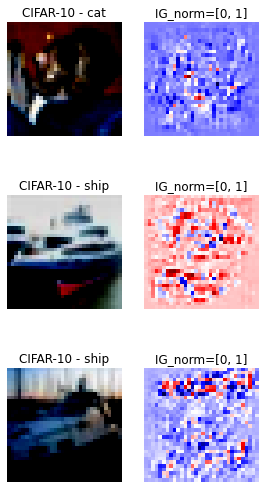

In [ ]:
# Load attributions and plot them. 
a_batch = quantus.explain(model, 
                          x_batch, 
                          y_batch, 
                          method="IntegratedGradients",
                          **{"normalize": True})

# Plot examplary inputs!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*1.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow(np.moveaxis(np.clip(x_batch[i].cpu().numpy(), 0, 1), 0, -1), 
                   vmin=0.0, vmax=1.0)
    axes[i, 0].title.set_text(f"CIFAR-10 - {classes[y_batch[i].item()]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(a_batch[i], cmap="seismic")
    axes[i, 1].title.set_text(f"IG_norm=[0, 1]")
    axes[i, 1].axis("off")
plt.show()

### Meaure sensitivity of hyperparameter choice.

We want to understand how sensitive the evaluation outome of Faithfulness Correlation (Bhatt et al., 2020) is from its hyperparameters.

In [ ]:
# Let's list the default parameters of the metric.
metric = quantus.FaithfulnessCorrelation()
metric.list_hyperparameters

{'abs': True,
 'default_plot_func': typing.Callable,
 'normalize': True,
 'normalize_func': <function quantus.helpers.normalize_func.normalize_by_max>,
 'nr_runs': 100,
 'perturb_baseline': 'black',
 'perturb_func': <function quantus.helpers.perturb_func.baseline_replacement_by_indices>,
 'similarity_func': <function quantus.helpers.similar_func.correlation_pearson>,
 'subset_size': 224,
 'text_warning': "\nThe Faithfulness correlation metric is known to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'. Go over and select each hyperparameter of the SelectivityN metric carefully to avoid misinterpretation of scores. To view all relevant hyperparameters call .list_hyperparameters method. For further reading, please see [CITATION].\n"}

In [ ]:
# Define some parameter settings to evaluate.
baseline_strategies = ["mean", "random", "uniform", "black", "white"]
subset_sizes = np.arange(2, 128, 4)

# Recompute some Saliency explanations.
a_batch = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()

# Metric class expects numpy arrays.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

In [ ]:
# Reinitalise the metric and then do a model call (in a one-liner!) while including the different tunable parameters.
results = {
    s: {b: np.mean(quantus.FaithfulnessCorrelation({'abs': True,
                                                    'normalize': True,
                                                    'normalize_func': quantus.normalize_by_max,
                                                    'nr_runs': 100,
                                                    'perturb_baseline': b,
                                                    'perturb_func': quantus.baseline_replacement_by_indices,
                                                    'similarity_func': quantus.correlation_pearson,
                                                    'subset_size': s})(model=model.cuda(), 
                                                                        x_batch=x_batch, 
                                                                        y_batch=y_batch,
                                                                        a_batch=a_batch,
                                                                        **{"device": device}))
    for b in baseline_strategies}
    for s in subset_sizes
}

In [ ]:
# Summarise in a dataframe.      
df = pd.DataFrame(results)
df

,2,6,10,14,18,22,26,30,34,38,42,46,50,54,58,62,66,70,74,78,82,86,90,94,98,102,106,110,114,118,122,126
mean,0.020745,0.018590,-0.040082,0.040290,0.082875,-0.023463,0.006063,0.026755,0.050545,-0.014385,0.028247,0.083805,0.047486,0.013748,0.040075,0.040545,0.030147,0.056251,-0.013200,0.025118,0.007553,0.030058,0.053095,0.041097,0.049251,0.033162,0.034311,0.018057,0.033267,0.060634,0.039857,0.056552
random,0.041393,0.005001,0.023067,0.015448,0.070602,0.027278,0.080576,0.015462,0.065432,0.064111,0.061573,0.059718,0.010730,0.027517,0.031285,0.043364,-0.044254,0.001753,0.002718,0.059409,-0.000456,-0.003428,-0.002427,0.106144,0.016055,0.087428,0.038017,0.021306,0.046274,0.017992,0.054760,-0.015435
uniform,0.093936,0.064311,0.014469,0.007601,0.028033,0.041964,0.074758,-0.006129,0.051577,-0.002610,0.036758,0.076336,0.020190,0.032253,0.040945,0.011642,-0.025484,0.052727,0.029332,0.006569,0.020833,0.014882,-0.029039,0.029329,0.018683,0.016314,0.008364,0.063420,0.065084,0.037319,0.099687,0.000715
black,0.039742,0.021472,0.020138,0.002027,0.037725,0.039713,0.043861,0.017947,0.002174,0.061652,0.017680,0.050951,0.026102,0.013179,0.056788,0.029102,0.023302,0.005596,0.000396,0.050762,-0.009611,0.017855,0.076990,0.008066,0.036579,0.026435,0.060067,0.027082,-0.001851,-0.024024,0.016625,0.100291
white,0.025710,0.032313,0.024232,0.001517,-0.006268,0.053135,0.010063,0.031316,0.094868,0.016019,0.039272,-0.028451,0.014320,0.092372,0.059925,0.002383,0.047812,0.007112,-0.031913,-0.030553,-0.033006,0.040666,0.027255,-0.066321,0.023054,0.024730,0.078231,0.050483,0.002368,0.033531,0.025012,-0.018688


In [ ]:
# Inspect the standard deviation of faithfulness scores - when it comes to baselines.
print(f"Standard deviation: {df.std(axis=1).mean():.2f}\n{df.std(axis=1)}")

Standard deviation: 0.03
mean       0.027572
random     0.032963
uniform    0.031391
black      0.026129
white      0.036532
dtype: float64


In [ ]:
# Inspect the standard deviation of faithfulness scores - when it comes to subset sizes.
print(f"Standard deviation: {df.std(axis=0).mean():.2f}\n{df.std(axis=0)}")

Standard deviation: 0.03
2      0.029126
6      0.022342
10     0.027345
14     0.016058
18     0.035462
22     0.030052
26     0.034894
30     0.014477
34     0.033537
38     0.036288
42     0.016267
46     0.044930
50     0.014492
54     0.032709
58     0.012117
62     0.017922
66     0.039201
70     0.027303
74     0.022519
78     0.036180
82     0.020186
86     0.016643
90     0.042337
94     0.062208
98     0.013933
102    0.028486
106    0.026596
110    0.019868
114    0.028634
118    0.031412
122    0.032761
126    0.051955
dtype: float64


In [ ]:
# Let's next investigate how often the ranking between two explanation methods (which one sores highest) changes as we evaluate with the same
# evaluation technique albeit with slightly different hyperparameter settings.
# (our hope is here, that the metric is "stable" enough to favour one of the two explanation method as better - independent of the evaluation settings!)

a_batch_ig = IntegratedGradients(model.to(device)).attribute(inputs=torch.Tensor((x_batch)).to(device), 
                                                             target=torch.LongTensor(y_batch).to(device), 
                                                             baselines=torch.zeros_like(torch.Tensor(x_batch)).to(device), 
                                                             n_steps=10, 
                                                             method="riemann_trapezoid").sum(axis=1).cpu().numpy()

In [ ]:
# Reinitalise the metric with Integrated Gradients explanations.
results_ig = {
    s: {b: np.mean(quantus.FaithfulnessCorrelation({'abs': True,
                                                    'normalize': True,
                                                    'normalize_func': quantus.normalize_by_max,
                                                    'nr_runs': 100,
                                                    'perturb_baseline': b,
                                                    'perturb_func': quantus.baseline_replacement_by_indices,
                                                    'similarity_func': quantus.correlation_pearson,
                                                    'subset_size': s,})(model=model.cuda(), 
                                                                        x_batch=x_batch, 
                                                                        y_batch=y_batch,
                                                                        a_batch=a_batch_ig,
                                                                        **{"device": device}))
    for b in baseline_strategies}
    for s in subset_sizes
}

In [ ]:
# Summarise in a dataframe.      
df_ig = pd.DataFrame(results_ig)
df_ig

,2,6,10,14,18,22,26,30,34,38,42,46,50,54,58,62,66,70,74,78,82,86,90,94,98,102,106,110,114,118,122,126
mean,0.044578,0.006085,0.058851,0.046748,0.060648,0.071795,0.072186,0.021987,0.018675,0.018724,0.090579,0.115557,0.045925,-0.006808,0.012860,0.025904,0.027752,0.080388,0.066188,0.067146,0.057892,0.048015,0.043831,0.012592,0.059238,0.061937,-0.005211,0.005626,0.020351,0.030644,0.057317,0.061130
random,0.005249,-0.002048,0.054432,0.006769,0.044468,0.049381,0.043790,0.027329,0.027832,-0.000225,0.049747,0.012592,0.041162,0.004278,0.022446,0.055593,0.025427,0.004463,0.017491,0.039072,0.053376,0.005917,0.050553,0.017773,0.083288,0.058710,0.036349,0.075583,0.024563,0.029529,0.068328,0.015351
uniform,0.051941,0.000007,0.025624,0.020975,0.069103,0.013400,0.046854,0.021957,0.063320,0.049114,0.029749,-0.016288,0.046385,0.025662,0.040414,-0.032827,0.046825,0.029370,0.048044,0.019846,0.028022,0.018382,0.066529,-0.005600,0.039997,0.060426,0.022027,0.011104,0.062930,0.068539,0.060972,0.041373
black,0.048417,0.026024,0.062696,0.091056,0.048219,-0.005191,0.084252,-0.002228,0.034959,0.065476,-0.001372,0.016340,0.072780,0.047791,0.081025,0.030813,0.053527,0.092338,0.037529,0.043271,0.063916,0.042193,0.033785,0.014040,-0.006132,0.057472,-0.026287,0.034426,0.072541,0.028811,-0.034751,0.016231
white,0.021996,0.029135,0.087411,-0.010703,0.050661,-0.013451,0.073544,0.070585,-0.020221,0.008718,0.010538,-0.003187,0.035503,-0.004478,0.045816,0.017326,0.050868,0.004518,0.022839,0.087506,0.030356,0.082296,0.038011,0.083819,-0.040208,0.072144,0.041990,-0.004488,0.087177,0.040485,0.079447,-0.016378


It is quite astonishing that the relative ranking of explanation methods are close to chance! 

In [ ]:
# How often is faithfulness correlation of Integrated Gradient explanations higher than that of Saliency explanations
condition = np.array([np.greater(b, a) for i, ig in zip(df.to_numpy(), df_ig.to_numpy()) for a, b in zip(i, ig)]).astype(int)

print(f"Faithfulness scores by Bhatt et al., 2020 are higher for IG than Salieny attributions in:" \
      f"\n{int(condition.sum())} out of {len(condition)} combinations i.e., {condition.mean()*100:.1f}% of the time (or {(0.5-condition.mean())*100:.2f} points from chance!).")

Faithfulness scores by Bhatt et al., 2020 are higher for IG than Salieny attributions in:
92 out of 160 combinations i.e., 57.5% of the time (or -7.50 points from chance).
